In [1]:
# read j3 wrf ts files

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils import Tower
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram
import matplotlib.colors as mcolors

obs_dir = '/projects/mmcpnnl/sgp_obs/'
wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

# obs
dlprofwind_ncs = obs_dir+'sgpdlprofwind4newsC1.c1/*.nc'
dlprofwstats_ncs = obs_dir+'sgpdlprofwstats4newsC1.c1/*.nc'

dlprofwind = xr.open_mfdataset(dlprofwind_ncs)
dlprofwstats = xr.open_mfdataset(dlprofwstats_ncs)

# according to Rob Newsom, lidar data taken < 100 m need to be thrown out
toss_wp_data_below_height = 100

# vertical profile plot top height threshold
profile_hgt_thres = 2000

# plotting variables
dlprofwind_dict = {'ws': ['wind_speed', r'ws (m s$^{-1}$)'], 'wd': ['wind_direction', 'wd (deg)']}
dlprofwstats_dict = {'w': ['w', r'w (m s$^{-1}$)']}

In [2]:
# time step of wrf runs
d02_wrf_dt = 10
d04_wrf_dt = 0.4

# tower location & domain number to analyze
sim_dict = {'meso': ['c1.d02', d02_wrf_dt], 'les': ['c1.d04', d04_wrf_dt]}

les_avg_time = '15Min'

les_spinup = np.timedelta64(1, 'h')

eval_date = '2018-08-05'

In [3]:
def read_tower_to_ds(tower, wrf_start, dt, lev): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=lev, height_var='ph', agl=True)

    # wind speed
    ds['ws'] = np.sqrt(ds['u']**2 + ds['v']**2)
    
    # wind direction
    ds['wd'] = np.mod(180 + np.rad2deg(np.arctan2(ds['u'], ds['v'])), 360) # checked wd, correct

    return ds

def get_wp_height_list(wp_ds):

    wp_height_list = list(wp_ds.height.where((wp_ds.height > toss_wp_data_below_height)).values)
    
    return [x for x in wp_height_list if str(x) != 'nan']

def read_wp_wrf_1day(obs, eval_date, row): 
    
    date_col = data_dir_df[eval_date]

    # start date & end date are the same because only looking at 24 hours of data
    obs_ds = obs.sel(time=slice(eval_date, eval_date))

    # for lidar...
    obs_height_list = get_wp_height_list(obs_ds)
    obs_ds = obs_ds.sel(height=obs_height_list)
    
    # select more model heights than obs
    wrf_height_list = obs_height_list+list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
    wrf_height_list.sort()
    
    wrf_meso_dir = wrf_runs_dir+date_col[row]+'/'
    c1_meso_file_path = wrf_meso_dir+'z_ts/z.'+sim_dict['meso'][0]
    meso_tower = Tower(c1_meso_file_path)
    
    wrf_les_dir = wrf_runs_dir+date_col[row]+'/'
    c1_les_file_path = wrf_les_dir+'z_ts/z.'+sim_dict['les'][0]
    les_tower = Tower(c1_les_file_path)

    # simulation start time
    wrf_start = date_col['wrf_start']

    wrf_meso_ds = read_tower_to_ds(meso_tower, wrf_start, sim_dict['meso'][1], wrf_height_list)
    wrf_les_ds = read_tower_to_ds(les_tower, wrf_start, sim_dict['les'][1], wrf_height_list)

    return obs_ds, wrf_meso_ds, wrf_les_ds

# if obs.platform_id == 'dlprofwind4news': 
#     var_dict = dlprofwind_dict
# if obs.platform_id == 'dlprofwstats4news': 
#     var_dict = dlprofwstats_dict

obs_ds, wrf_meso_ds, wrf_les_ds = read_wp_wrf_1day(dlprofwind, eval_date, 'mynn')

In [31]:
sim_dict['meso'][1]

10

In [13]:
dlprofwind

<xarray.Dataset>
Dimensions:               (bound: 2, height: 164, time: 14684)
Coordinates:
  * time                  (time) datetime64[ns] 2018-05-01T00:00:44.116244 .....
  * height                (height) float32 90.93 116.9 ... 4.3e+03 4.326e+03
Dimensions without coordinates: bound
Data variables:
    base_time             (time) datetime64[ns] 2018-05-01 ... 2018-09-30
    time_offset           (time) datetime64[ns] dask.array<chunksize=(96,), meta=np.ndarray>
    time_bounds           (time, bound) datetime64[ns] dask.array<chunksize=(96, 2), meta=np.ndarray>
    scan_duration         (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    elevation_angle       (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    nbeams                (time) int16 dask.array<chunksize=(96,), meta=np.ndarray>
    u                     (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    u_error               (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    v                     (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    v_error               (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    w                     (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    w_error               (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_speed            (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_speed_error      (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_direction        (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    wind_direction_error  (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    residual              (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    correlation           (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    mean_snr              (time, height) float32 dask.array<chunksize=(96, 164), meta=np.ndarray>
    snr_threshold         (time) float64 0.008 0.008 0.008 ... 0.008 0.008 0.008
    met_wspd              (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_wdir              (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr               (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr_min           (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_spr_max           (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    met_dt                (time) float64 300.0 300.0 300.0 ... 300.0 300.0 300.0
    met_lat               (time) float64 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6
    met_lon               (time) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49
    met_alt               (time) float64 318.0 318.0 318.0 ... 318.0 318.0 318.0
    lat                   (time) float32 36.61 36.61 36.61 ... 36.61 36.61 36.61
    lon                   (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    alt                   (time) float32 317.0 317.0 317.0 ... 317.0 317.0 317.0
Attributes:
    process_version:       vap-dlprof_wind-0.8-0.el6
    command_line:          idl -R -n dlprof_wind -s sgp -f C1 -d 20180501
    dod_version:           dlprofwind4news-c1-1.0
    Conventions:           ARM-1.1
    site_id:               sgp
    platform_id:           dlprofwind4news
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpdlprofwind4newsC1.c1
    data_level:            c1
    facility_id:           C1
    input_datastreams:     sgpdlppiC1.b1 : 2.14 : 20180501.000021-20180501.23...
    dlat:                  36.60529
    dlon:                  -97.48658
    serial_number:         0116-107
    doi:                   DOI:10.5439/1178582
    doi_url:               http://dx.doi.org/10.5439/1178582
    history:               created by use

In [15]:
data_dir_df

,2018-08-05,2018-09-01
mynn,l1_0805m,0901m
edmf,l2_0805e,0901e
wrf_start,8/4/18 12:00,8/31/18 12:00


In [23]:
data_dir_df.index

Index(['mynn', 'edmf', 'wrf_start'], dtype='object')

In [43]:
obs_ds.sel(time=slice(time_start, time_end))['time']

<xarray.DataArray 'time' (time: 32)>
array(['2018-08-05T16:00:45.822429000', '2018-08-05T16:15:29.204749000',
       '2018-08-05T16:30:31.024360000', '2018-08-05T16:45:29.760932000',
       '2018-08-05T17:00:43.347072000', '2018-08-05T17:15:30.240725000',
       '2018-08-05T17:30:29.181575000', '2018-08-05T17:45:31.171130000',
       '2018-08-05T18:00:44.837951000', '2018-08-05T18:15:31.244945000',
       '2018-08-05T18:30:29.936885000', '2018-08-05T18:45:28.795337000',
       '2018-08-05T19:00:45.829295000', '2018-08-05T19:15:30.173778000',
       '2018-08-05T19:30:29.507732000', '2018-08-05T19:45:31.532477000',
       '2018-08-05T20:00:45.732307000', '2018-08-05T20:15:29.414176000',
       '2018-08-05T20:30:28.777312000', '2018-08-05T20:45:31.124782000',
       '2018-08-05T21:00:45.033645000', '2018-08-05T21:15:29.076003000',
       '2018-08-05T21:30:31.178855000', '2018-08-05T21:45:30.196094000',
       '2018-08-05T22:00:44.313525000', '2018-08-05T22:15:31.305026000',
       '2018-08-05T22:30:30.233859000', '2018-08-05T22:45:29.153251000',
       '2018-08-05T23:00:46.212100000', '2018-08-05T23:15:30.047606000',
       '2018-08-05T23:30:28.782462000', '2018-08-05T23:45:30.990027000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-08-05T16:00:45.822429 ... 2018-08-05T...
Attributes:
    long_name:  Time offset from midnight
    bounds:     time_bounds

In [4]:
wrf_dict = {'mynn': wrf_meso_ds, 'mynn-les': wrf_les_ds}

# get start & end time to trim time series
time_start = np.max([wrf_meso_ds['datetime'].min().values, wrf_les_ds['datetime'].min().values, 
                     obs_ds['time'].min().values]) + les_spinup
time_end = np.min([wrf_meso_ds['datetime'].max().values, wrf_les_ds['datetime'].max().values, 
                   obs_ds['time'].max().values])

# start w/ obs
time_freq = obs_ds.sel(time=slice(time_start, time_end))['time']

wrf_les_ds_cut = wrf_les_ds.sel(datetime=slice(time_start, wrf_les_ds['datetime'].max().values))

wrf_les_ds_mean = wrf_les_ds_cut.resample(datetime=les_avg_time).mean()
wrf_les_ds_std = wrf_les_ds_cut.resample(datetime=les_avg_time).std()

In [5]:
time_freq

<xarray.DataArray 'time' (time: 32)>
array(['2018-08-05T16:00:45.822429000', '2018-08-05T16:15:29.204749000',
       '2018-08-05T16:30:31.024360000', '2018-08-05T16:45:29.760932000',
       '2018-08-05T17:00:43.347072000', '2018-08-05T17:15:30.240725000',
       '2018-08-05T17:30:29.181575000', '2018-08-05T17:45:31.171130000',
       '2018-08-05T18:00:44.837951000', '2018-08-05T18:15:31.244945000',
       '2018-08-05T18:30:29.936885000', '2018-08-05T18:45:28.795337000',
       '2018-08-05T19:00:45.829295000', '2018-08-05T19:15:30.173778000',
       '2018-08-05T19:30:29.507732000', '2018-08-05T19:45:31.532477000',
       '2018-08-05T20:00:45.732307000', '2018-08-05T20:15:29.414176000',
       '2018-08-05T20:30:28.777312000', '2018-08-05T20:45:31.124782000',
       '2018-08-05T21:00:45.033645000', '2018-08-05T21:15:29.076003000',
       '2018-08-05T21:30:31.178855000', '2018-08-05T21:45:30.196094000',
       '2018-08-05T22:00:44.313525000', '2018-08-05T22:15:31.305026000',
       '2018-08-05T22:30:30.233859000', '2018-08-05T22:45:29.153251000',
       '2018-08-05T23:00:46.212100000', '2018-08-05T23:15:30.047606000',
       '2018-08-05T23:30:28.782462000', '2018-08-05T23:45:30.990027000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-08-05T16:00:45.822429 ... 2018-08-05T...
Attributes:
    long_name:  Time offset from midnight
    bounds:     time_bounds

In [9]:
def plot_wp_ts_profile(eval_date, wrf_run, wrf_ds, wp_ds, wrf_var, wp_var, var_units, freq, wrf_std_ds=None): 
    
    ts_lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
    lw = 1

    # reverse height list, useful for plotting
    wp_height_list = get_wp_height_list(wp_ds)[:len(ts_lc_list)][::-1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    for hgt, lc in enumerate(ts_lc_list): 

        # slice of data at each height
        wrf_1height = wrf_ds.sel(height=wp_height_list[hgt])
        wp_1height = wp_ds.sel(height=wp_height_list[hgt])

        ax[0].plot(wrf_1height['datetime'], wrf_1height[wrf_var], 
                 label=str(np.round(wrf_1height['height'].values).astype(int))+' m', 
                 c=lc, linewidth=lw)
        ax[0].plot(wp_1height['time'], wp_1height[wp_var], c=lc, linewidth=lw, linestyle='--')
        
        if wrf_std_ds is not None: 
            
            wrf_std_1height = wrf_std_ds.sel(height=wp_height_list[hgt])
            
            ax[0].fill_between(wrf_std_1height['datetime'], 
                               wrf_1height[wrf_var].squeeze()+wrf_std_1height[wrf_var].squeeze(), 
                               wrf_1height[wrf_var].squeeze()-wrf_std_1height[wrf_var].squeeze(), 
                               alpha=0.1)

    ax[0].tick_params(labelrotation=90)
    # 24 hours of data in plot
    ax[0].set_xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
    ax[0].set_xlabel('UTC time (Z)')
    ax[0].set_ylabel(var_units)
    ax[0].legend(title=wrf_run)

    wrf_synctime = wrf_ds.sel(datetime=freq, method='nearest')
    wp_synctime = wp_ds.sel(time=freq, method='nearest')

    wrf_hgt_top_i = (wrf_synctime['height'] < profile_hgt_thres).sum().values
    wp_hgt_top_i = (wp_synctime['height'] < profile_hgt_thres).sum().values
    
    profile_lc = list(mcolors.TABLEAU_COLORS)

    for ind, time_i in enumerate(list(range(len(wp_synctime['time']))[0::8])): 

        wrf_time = wrf_synctime['datetime'][time_i].values.astype('datetime64[s]').tolist()

        ax[1].plot(wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
                   wrf_synctime['height'][:wrf_hgt_top_i], 
                   c=profile_lc[ind], label='%02d'%wrf_time.hour+':'+'%02d'%wrf_time.minute+'Z')
        ax[1].plot(wp_synctime[wp_var][time_i, :wp_hgt_top_i], 
                   wp_synctime['height'][:wp_hgt_top_i], 
                   linestyle='--', c=profile_lc[ind])
        
        if wrf_std_ds is not None: 
            
            wrf_std_synctime = wrf_std_ds.sel(datetime=freq, method='nearest')
            
            ax[1].fill_betweenx(
                wrf_synctime['height'][:wrf_hgt_top_i],
                wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0]\
                +wrf_std_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
                wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0]\
                -wrf_std_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
                                
                   color=profile_lc[ind], alpha=0.1)

    ax[1].set_ylabel('Height AGL (m)')
    ax[1].set_xlabel(var_units)
    ax[1].legend(title=wrf_run)
    
    plt.suptitle(wp_var+': '+wrf_run+' (solid) vs '+wp_ds.platform_id+' (dashed): '+eval_date)

#     plt.savefig('plots_03a/ts_prof_'+eval_date+'_'+wp_var+'_'+wrf_run+'.pdf')
    
    plt.show()
    plt.close(fig)

######################################################################


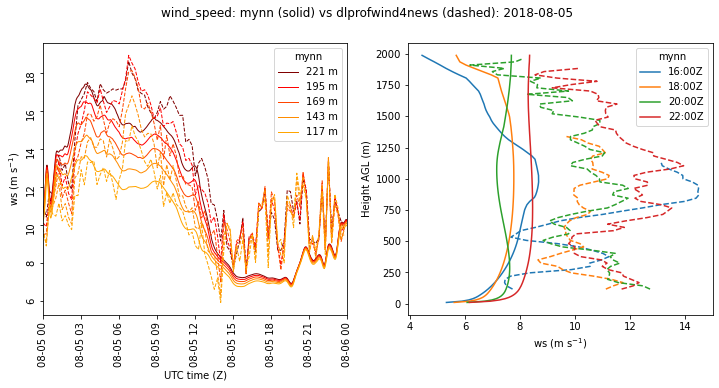

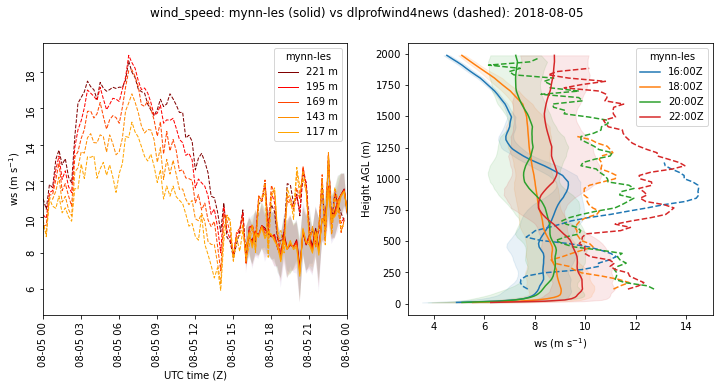

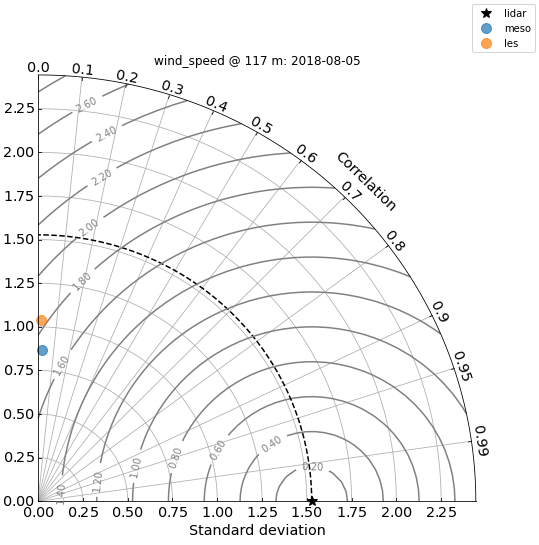

######################################################################


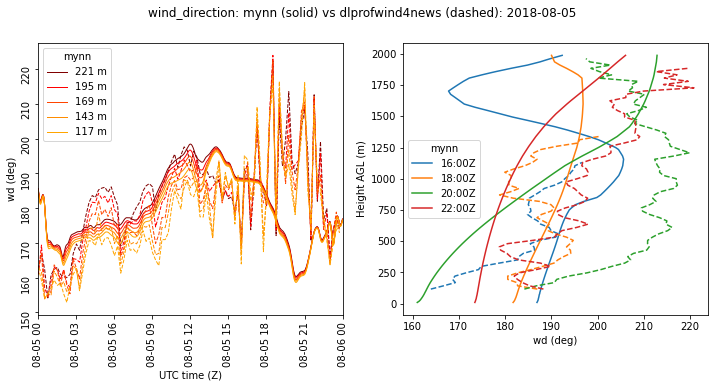

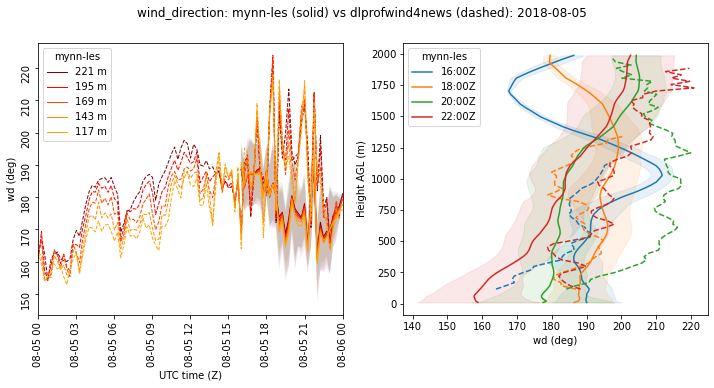

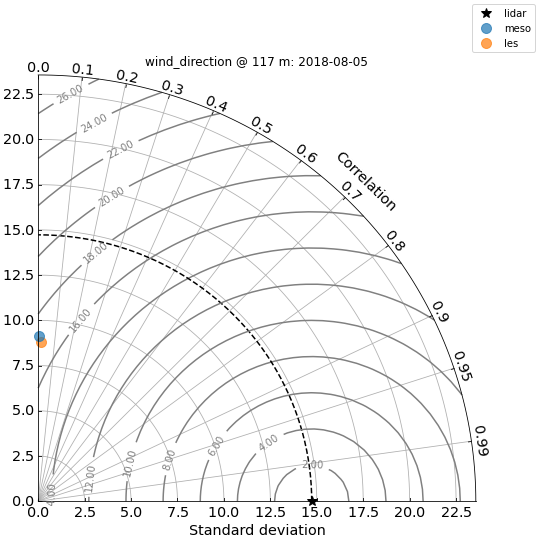

In [10]:
# refer to the most infrequent data series
# need matching time dimension to calculate correlation, etc. 
for model in [wrf_meso_ds, wrf_les_ds]: 

    model_time_freq = model.sel(datetime=slice(time_start, time_end))['datetime']

    if len(time_freq) > len(model_time_freq): 

        time_freq = model_time_freq

obs_height_list = get_wp_height_list(obs_ds)

# taylor diagram for the 1st height
lev_i = 0

obs_slice = obs_ds.sel(height=obs_height_list[lev_i], time=time_freq, method='nearest')
wrf_meso_slice = wrf_meso_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
wrf_les_mean_slice = wrf_les_ds_mean.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
wrf_les_std_slice = wrf_les_ds_std.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')

for wrf_var, var in dlprofwind_dict.items():

    print('######################################################################')

#         for wrf_run, wrf_ds in wrf_dict.items(): 

    plot_wp_ts_profile(eval_date, 'mynn', wrf_meso_ds, obs_ds, wrf_var, var[0], var[1], time_freq)
    plot_wp_ts_profile(eval_date, 'mynn-les', wrf_les_ds_mean, obs_ds, wrf_var, var[0], var[1], 
                       time_freq, wrf_les_ds_std)

    models = {}
    models['meso'] = wrf_meso_slice[wrf_var]
    models['les'] = wrf_les_mean_slice[wrf_var]

    fig = plt.figure(figsize=(8, 8))
    td = TaylorDiagram(obs_slice[var[0]].std().values, label='lidar', fig=fig,
                       srange=(0, 1.6), extend=False,
                       corrticks=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99],
                       #minorcorrticks=np.arange(0.05,0.9,0.1),
                       #stdevticks=np.arange(0.2,2,0.2),
                       labelsize='x-large')

    for name, series in models.items():
        corr_xy = np.corrcoef(np.squeeze(obs_slice[var[0]]), np.squeeze(series))[0, 1]
        R2 = corr_xy**2
        stdev = series.std().values
        # print(name, stdev, R2)
        td.add_sample(stdev, R2, marker='o', ms=10, ls='', alpha=0.7, label=name)

    td.add_grid()

    contours = td.add_contours(levels=15, colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    fig.legend(td.samplePoints, [p.get_label() for p in td.samplePoints],
               numpoints=1, prop=dict(size='medium'), loc='upper right')

    hgt_str = str(np.round(obs_slice['height'].values).astype(int))

    plt.title(var[0]+' @ '+hgt_str+' m: '+eval_date)

#     plt.savefig('plots_03a/taydiag_'+eval_date+'_'+var[0]+'_'+hgt_str+'m.pdf')

    plt.show()
    plt.close('all')

#     del(obs_ds, wrf_mynn_ds, wrf_edmf_ds)

In [53]:
time_start+np.timedelta64(1, 'h')

numpy.datetime64('2018-08-05T16:00:00.000000000')

In [54]:
obs_slice

<xarray.Dataset>
Dimensions:               (bound: 2, time: 36)
Coordinates:
  * time                  (time) datetime64[ns] 2018-08-05T15:00:45.373963 .....
    height                float32 116.9
Dimensions without coordinates: bound
Data variables:
    base_time             (time) datetime64[ns] 2018-08-05 ... 2018-08-05
    time_offset           (time) datetime64[ns] dask.array<chunksize=(36,), meta=np.ndarray>
    time_bounds           (time, bound) datetime64[ns] dask.array<chunksize=(36, 2), meta=np.ndarray>
    scan_duration         (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    elevation_angle       (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    nbeams                (time) int16 dask.array<chunksize=(36,), meta=np.ndarray>
    u                     (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    u_error               (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    v                     (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    v_error               (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    w                     (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    w_error               (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    wind_speed            (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    wind_speed_error      (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    wind_direction        (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    wind_direction_error  (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    residual              (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    correlation           (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    mean_snr              (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    snr_threshold         (time) float64 0.008 0.008 0.008 ... 0.008 0.008 0.008
    met_wspd              (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    met_wdir              (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    met_spr               (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    met_spr_min           (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    met_spr_max           (time) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    met_dt                (time) float64 300.0 300.0 300.0 ... 300.0 300.0 300.0
    met_lat               (time) float64 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6
    met_lon               (time) float64 -97.49 -97.49 -97.49 ... -97.49 -97.49
    met_alt               (time) float64 318.0 318.0 318.0 ... 318.0 318.0 318.0
    lat                   (time) float32 36.61 36.61 36.61 ... 36.61 36.61 36.61
    lon                   (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    alt                   (time) float32 317.0 317.0 317.0 ... 317.0 317.0 317.0
Attributes:
    process_version:       vap-dlprof_wind-0.8-0.el6
    command_line:          idl -R -n dlprof_wind -s sgp -f C1 -d 20180501
    dod_version:           dlprofwind4news-c1-1.0
    Conventions:           ARM-1.1
    site_id:               sgp
    platform_id:           dlprofwind4news
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpdlprofwind4newsC1.c1
    data_level:            c1
    facility_id:           C1
    input_datastreams:     sgpdlppiC1.b1 : 2.14 : 20180501.000021-20180501.23...
    dlat:                  36.60529
    dlon:                  -97.48658
    serial_number:         0116-107
    doi:                   DOI:10.5439/1178582
    doi_url:               http://dx.doi.org/10.5439/1178582
    history:               created by user dsmgr on machine ruby at 2018-05-0...

In [49]:
wrf_meso_slice

<xarray.Dataset>
Dimensions:   (station: 1, time: 36)
Coordinates:
    datetime  (time) datetime64[ns] 2018-08-05T15:00:50 ... 2018-08-05T23:45:30
    height    float64 116.9
  * station   (station) <U4 'z.c1'
  * time      (time) datetime64[ns] 2018-08-05T15:00:45.373963 ... 2018-08-05...
Data variables:
    theta     (time, station) float64 304.2 304.7 305.2 ... 312.4 312.3 312.3
    pr        (time, station) float64 9.678e+04 9.678e+04 ... 9.636e+04
    w         (time, station) float64 -0.003485 -0.01372 ... -0.01996 -0.03226
    u         (time, station) float64 1.447 1.243 0.9725 ... -0.6422 -0.8288
    qv        (time, station) float64 0.01408 0.01405 0.014 ... 0.01091 0.01076
    v         (time, station) float64 6.771 6.681 6.697 ... 8.788 9.817 9.805
    i         (station) int64 122
    j         (station) int64 126
    lat       (station) float64 36.62
    lon       (station) float64 -97.49
    zsurface  (station) float64 306.8
    t2        (time, station) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0
    q2        (time, station) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0
    u10       (time, station) float64 0.7172 0.7251 0.7319 ... 0.6488 0.6283
    v10       (time, station) float64 51.2 48.3 45.36 ... 64.57 67.58 70.58
    psfc      (time, station) float64 596.3 641.0 683.5 ... 381.5 330.2 278.9
    lwd       (time, station) float64 792.3 807.9 821.6 ... 688.8 654.1 612.9
    swd       (time, station) float64 101.3 104.2 106.9 ... 85.06 80.08 74.47
    hfx       (time, station) float64 596.3 641.0 683.5 ... 381.5 330.2 278.9
    lfx       (time, station) float64 792.3 807.9 821.6 ... 688.8 654.1 612.9
    tsk       (time, station) float64 593.6 636.6 678.3 ... 389.9 339.0 287.7
    slttop    (time, station) float64 782.0 796.6 809.6 ... 686.8 653.5 613.5
    rainc     (time, station) float64 106.8 109.7 112.4 ... 91.76 86.63 80.72
    rainnc    (time, station) float64 593.7 636.7 678.4 ... 390.0 339.1 287.8
    clw       (time, station) float64 782.1 796.7 809.8 ... 687.0 653.6 613.6
    ws        (time, station) float64 6.924 6.795 6.767 ... 8.942 9.838 9.84
    wd        (time, station) float64 192.1 190.5 188.3 ... 169.4 176.3 175.2

In [38]:
wrf_meso_ds

<xarray.Dataset>
Dimensions:   (datetime: 12960, height: 200, station: 1)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-04T12:00:10 ... 2018-08-06
  * height    (height) float64 10.0 20.0 30.0 ... 4.274e+03 4.3e+03 4.326e+03
  * station   (station) <U4 'z.c1'
Data variables:
    theta     (datetime, height, station) float64 299.8 299.8 ... 320.6 320.7
    pr        (datetime, height, station) float64 9.781e+04 ... 5.919e+04
    w         (datetime, height, station) float64 -0.01187 -0.009347 ... 0.3375
    u         (datetime, height, station) float64 -0.902 -0.9168 ... 7.91 7.938
    qv        (datetime, height, station) float64 0.01008 0.01005 ... -0.0007924
    v         (datetime, height, station) float64 5.895 6.064 ... -3.966 -4.101
    i         (station) int64 122
    j         (station) int64 126
    lat       (station) float64 36.62
    lon       (station) float64 -97.49
    zsurface  (station) float64 306.8
    t2        (datetime, station) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0
    q2        (datetime, station) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0
    u10       (datetime, station) float64 0.3451 0.3451 0.3451 ... 0.609 0.609
    v10       (datetime, station) float64 86.8 86.77 86.74 ... 73.4 73.43 73.47
    psfc      (datetime, station) float64 25.63 25.63 25.63 ... 238.2 238.2
    lwd       (datetime, station) float64 113.0 113.0 113.0 ... 574.2 574.2
    swd       (datetime, station) float64 19.32 19.32 19.32 ... 69.44 69.44
    hfx       (datetime, station) float64 25.63 25.63 25.63 ... 238.2 238.2
    lfx       (datetime, station) float64 113.0 113.0 113.0 ... 574.2 574.2
    tsk       (datetime, station) float64 16.79 23.43 20.75 ... 238.7 238.1
    slttop    (datetime, station) float64 124.6 8.078 0.01539 ... 567.4 566.8
    rainc     (datetime, station) float64 10.45 23.01 20.75 ... 74.11 74.03
    rainnc    (datetime, station) float64 16.82 17.32 17.65 ... 238.8 238.2
    clw       (datetime, station) float64 124.9 126.1 127.4 ... 567.6 567.0
    ws        (datetime, height, station) float64 5.964 6.133 ... 8.849 8.935
    wd        (datetime, height, station) float64 171.3 171.4 ... 296.6 297.3

In [4]:

    
def plot_wp_ts_profile(eval_date, wrf_run, wrf_ds, wp_ds, wrf_var, wp_var, var_units, freq, wrf_std_ds=None): 
    
    ts_lc_list = ['maroon', 'red', 'orangered', 'darkorange', 'orange']
    lw = 1

    # reverse height list, useful for plotting
    wp_height_list = get_wp_height_list(wp_ds)[:len(ts_lc_list)][::-1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    for hgt, lc in enumerate(ts_lc_list): 

        # slice of data at each height
        wrf_1height = wrf_ds.sel(height=wp_height_list[hgt])
        wp_1height = wp_ds.sel(height=wp_height_list[hgt])

        ax[0].plot(wrf_1height['datetime'], wrf_1height[wrf_var], 
                 label=str(np.round(wrf_1height['height'].values).astype(int))+' m', 
                 c=lc, linewidth=lw)
        ax[0].plot(wp_1height['time'], wp_1height[wp_var], c=lc, linewidth=lw, linestyle='--')
        
        if wrf_std_ds is not None: 
            
            wrf_std_1height = wrf_std_ds.sel(height=wp_height_list[hgt])
            
#             print(wrf_1height[wrf_var].squeeze())
#             print(wrf_std_1height[wrf_var].values)
            
            ax[0].fill_between(wrf_std_1height['datetime'], 
                               wrf_1height[wrf_var].squeeze()+wrf_std_1height[wrf_var].squeeze(), 
                               wrf_1height[wrf_var].squeeze()-wrf_std_1height[wrf_var].squeeze(), 
                               alpha=0.1)

    ax[0].tick_params(labelrotation=90)
    # 24 hours of data in plot
    ax[0].set_xlim(parser.parse(eval_date), parser.parse(eval_date)+datetime.timedelta(days=1))
    ax[0].set_xlabel('UTC time (Z)')
    ax[0].set_ylabel(var_units)
    ax[0].legend(title=wrf_run)

    wrf_synctime = wrf_ds.sel(datetime=freq, method='nearest')
    wp_synctime = wp_ds.sel(time=freq, method='nearest')

    wrf_hgt_top_i = (wrf_synctime['height'] < profile_hgt_thres).sum().values
    wp_hgt_top_i = (wp_synctime['height'] < profile_hgt_thres).sum().values
    
#     print(list(wp_synctime['time']))
    
    profile_lc = list(mcolors.TABLEAU_COLORS)

    for ind, time_i in enumerate(list(range(len(wp_synctime['time']))[8::8])): 
        
#         print(time_i)

        wrf_time = wrf_synctime['time'][time_i].values.astype('datetime64[s]').tolist()
        
#         print(wrf_time)
        
        ax[1].plot(wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], wrf_synctime['height'][:wrf_hgt_top_i], 
                   c=profile_lc[ind], label='%02d'%wrf_time.hour+':'+'%02d'%wrf_time.minute+'Z')
        ax[1].plot(wp_synctime[wp_var][time_i, :wp_hgt_top_i], wp_synctime['height'][:wp_hgt_top_i], 
                   linestyle='--', c=profile_lc[ind])
        
        if wrf_std_ds is not None: 
            
            wrf_std_synctime = wrf_std_ds.sel(datetime=freq, method='nearest')
            
#             print(wrf_1height[wrf_var].squeeze())
#             print(wrf_std_1height[wrf_var].values)
        
#             ax[1].plot(wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0]+wrf_std_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
#                        wrf_synctime['height'][:wrf_hgt_top_i], 
#                    c=profile_lc[ind], label='%02d'%wrf_time.hour+':'+'%02d'%wrf_time.minute+'Z')
        
#             ax[1].plot(wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0]-wrf_std_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
#                        wrf_synctime['height'][:wrf_hgt_top_i], 
#                    c=profile_lc[ind], label='%02d'%wrf_time.hour+':'+'%02d'%wrf_time.minute+'Z')
            
            ax[1].fill_betweenx(wrf_synctime['height'][:wrf_hgt_top_i],
                wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0]+wrf_std_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
                               wrf_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0]-wrf_std_synctime[wrf_var][time_i, :wrf_hgt_top_i, 0], 
                                
                   color=profile_lc[ind], alpha=0.1)

    ax[1].set_ylabel('Height AGL (m)')
    ax[1].set_xlabel(var_units)
    ax[1].legend(title=wrf_run)
    
    plt.suptitle(wp_var+': '+wrf_run+' (solid) vs '+wp_ds.platform_id+' (dashed): '+eval_date)

#     plt.savefig('plots_03a/ts_prof_'+eval_date+'_'+wp_var+'_'+wrf_run+'.pdf')
    
    plt.show()
    plt.close(fig)

def read_wp_wrf_1day(obs, eval_date): 
    
    date_col = data_dir_df[eval_date]

    # start date & end date are the same because only looking at 24 hours of data
    obs_ds = obs.sel(time=slice(eval_date, eval_date))

    # for lidar...
    obs_height_list = get_wp_height_list(obs_ds)
    obs_ds = obs_ds.sel(height=obs_height_list)
    
    # select more model heights than obs
    wrf_height_list = obs_height_list+list(range(10, 101))[0::10]+list(range(350, 3000))[0::100]
    wrf_height_list.sort()
    
    c1_file_name = 'z.c1.d02'
    
    wrf_mynn_dir = wrf_runs_dir+date_col['mynn']+'/'
    c1_mynn_file_path = wrf_mynn_dir+c1_file_name
    mynn_tower = Tower(c1_mynn_file_path)
    
    wrf_edmf_dir = wrf_runs_dir+date_col['edmf']+'/'
    c1_edmf_file_path = wrf_edmf_dir+'z.c1.d04'
    edmf_tower = Tower(c1_edmf_file_path)

    # simulation start time
    wrf_start = date_col['wrf_start']

#     tower_list = [mynn_tower, edmf_tower]
#     dt_list = [wrf_dt, erad02_wrf_dt, gfs_wrf_dt]

    wrf_mynn_ds = read_tower_to_ds(mynn_tower, wrf_start, d02_wrf_dt, wrf_height_list)
    wrf_edmf_ds = read_tower_to_ds(edmf_tower, wrf_start, d04_wrf_dt, wrf_height_list)
    
    wrf_les_ds_mean = wrf_edmf_ds.resample(datetime='15Min').mean()
    wrf_les_ds_std = wrf_edmf_ds.resample(datetime='15Min').std()

    return obs_ds, wrf_mynn_ds, wrf_les_ds_mean, wrf_les_ds_std

def plot_wp_wrf_ts_taydiag(obs, eval_date, lev_i=0): 
    
    print(eval_date)
    print(obs.platform_id)
    
    if obs.platform_id == 'dlprofwind4news': 
        var_dict = dlprofwind_dict
    if obs.platform_id == 'dlprofwstats4news': 
        var_dict = dlprofwstats_dict

    obs_ds, wrf_mynn_ds, wrf_les_ds_mean, wrf_les_ds_std = read_wp_wrf_1day(obs, eval_date)
    
    wrf_dict = {'mynn': wrf_mynn_ds, 'mynn-les': wrf_les_ds_mean}

    # get start & end time to trim time series
    time_start = np.max([wrf_mynn_ds['datetime'].min().values, wrf_les_ds_mean['datetime'].min().values, 
                         obs_ds['time'].min().values])
    time_end = np.min([wrf_mynn_ds['datetime'].max().values, wrf_les_ds_mean['datetime'].max().values, 
                       obs_ds['time'].max().values])

    # start w/ obs
    time_freq = obs_ds.sel(time=slice(time_start, time_end))['time']

    # refer to the most infrequent data series
    # need matching time dimension to calculate correlation, etc. 
    for model in [wrf_mynn_ds, wrf_les_ds_mean]: 

        model_time_freq = model.sel(datetime=slice(time_start, time_end))['datetime']

        if len(time_freq) > len(model_time_freq): 

            time_freq = model_time_freq
            
    obs_height_list = get_wp_height_list(obs_ds)

    return eval_date, obs_ds, wrf_mynn_ds, wrf_les_ds_mean, wrf_les_ds_std, var_dict, time_freq
    
#     obs_slice = obs_ds.sel(height=obs_height_list[lev_i], time=time_freq, method='nearest')
#     wrf_mynn_slice = wrf_mynn_ds.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
#     wrf_les_mean_slice = wrf_les_ds_mean.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')
#     wrf_les_std_slice = wrf_les_ds_std.sel(height=obs_height_list[lev_i], datetime=time_freq, method='nearest')

#     for wrf_var, var in var_dict.items():
        
#         print('######################################################################')
        
# #         for wrf_run, wrf_ds in wrf_dict.items(): 

#         plot_wp_ts_profile(eval_date, 'mynn', wrf_mynn_ds, obs_ds, wrf_var, var[0], var[1], time_freq)
#         plot_wp_ts_profile(eval_date, 'mynn-les', wrf_les_ds_mean, obs_ds, wrf_var, var[0], var[1], 
#                            time_freq, wrf_les_ds_std)

#         models = {}
#         models['mynn'] = wrf_mynn_slice[wrf_var]
#         models['edmf'] = wrf_edmf_slice[wrf_var]

# #         fig = plt.figure(figsize=(8, 8))
# #         td = TaylorDiagram(obs_slice[var[0]].std().values, label='lidar', fig=fig,
# #                            srange=(0, 1.6), extend=False,
# #                            corrticks=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99],
# #                            #minorcorrticks=np.arange(0.05,0.9,0.1),
# #                            #stdevticks=np.arange(0.2,2,0.2),
# #                            labelsize='x-large')

# #         for name, series in models.items():
# #             corr_xy = np.corrcoef(np.squeeze(obs_slice[var[0]]), np.squeeze(series))[0, 1]
# #             R2 = corr_xy**2
# #             stdev = series.std().values
# #             # print(name, stdev, R2)
# #             td.add_sample(stdev, R2, marker='o', ms=10, ls='', alpha=0.7, label=name)

# #         td.add_grid()

# #         contours = td.add_contours(levels=15, colors='0.5')
# #         plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

# #         fig.legend(td.samplePoints, [p.get_label() for p in td.samplePoints],
# #                    numpoints=1, prop=dict(size='medium'), loc='upper right')

# #         hgt_str = str(np.round(obs_slice['height'].values).astype(int))
        
# #         plt.title(var[0]+' @ '+hgt_str+' m: '+eval_date)
        
# #         plt.savefig('plots_03a/taydiag_'+eval_date+'_'+var[0]+'_'+hgt_str+'m.pdf')

# #         plt.show()
#         plt.close('all')
    
#     del(obs_ds, wrf_mynn_ds, wrf_edmf_ds)

In [6]:
var_dict

NameError: name 'var_dict' is not defined

In [5]:
for wrf_var, var in var_dict.items():

    plot_wp_ts_profile(eval_date, 'mynn', wrf_mynn_ds, obs_ds, wrf_var, var[0], var[1], time_freq)
    plot_wp_ts_profile(eval_date, 'mynn-les', wrf_les_ds_mean, obs_ds, wrf_var, var[0], var[1], 
                       time_freq, wrf_les_ds_std)

NameError: name 'var_dict' is not defined

In [38]:
x = np.arange(0.0, 2, 0.01)
x

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [25]:
for col in data_dir_df.columns[:1]: 
#     plot_wp_wrf_ts_taydiag(dlprofwind, col)
    eval_date, obs_ds, wrf_mynn_ds, wrf_les_ds_mean, wrf_les_ds_std, var_dict, time_freq = plot_wp_wrf_ts_taydiag(dlprofwind, col)

2018-08-05
dlprofwind4news


2018-08-05
dlprofwind4news
######################################################################


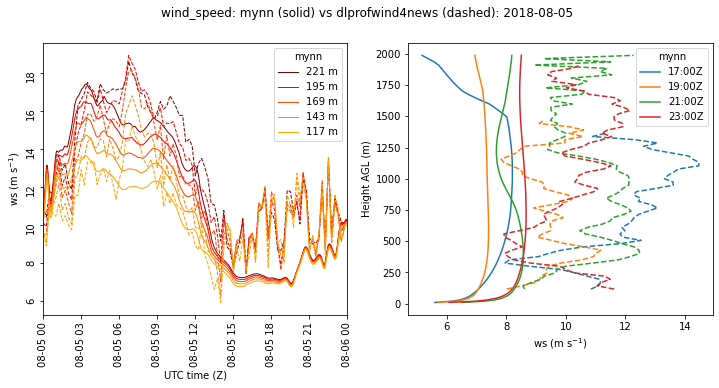

<xarray.DataArray 'ws' (datetime: 181, station: 1)>
array([[ 8.61878111],
       [ 6.98480021],
       [ 7.67289785],
       [ 8.33527392],
       [ 8.41997046],
       [ 9.1704182 ],
       [ 8.34710173],
       [ 8.5387302 ],
       [ 8.22406301],
       [ 8.98705085],
       [ 9.31190257],
       [ 8.24519859],
       [ 8.5387639 ],
       [ 8.54342753],
       [ 8.55747475],
       [ 7.80473379],
       [ 9.14198841],
       [ 8.68276512],
       [ 9.47032389],
       [ 8.56918257],
...
       [ 9.51089877],
       [11.35558165],
       [11.31669672],
       [ 9.88998136],
       [10.6548232 ],
       [12.06748427],
       [10.51585606],
       [ 9.60979153],
       [11.62668303],
       [10.62357584],
       [12.31880049],
       [10.38176593],
       [11.34183769],
       [11.48003765],
       [10.65651533],
       [12.04856326],
       [12.2575385 ],
       [11.83648924],
       [10.93007161],
       [10.14178419]])
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-05

ValueError: 'y1' is not 1-dimensional

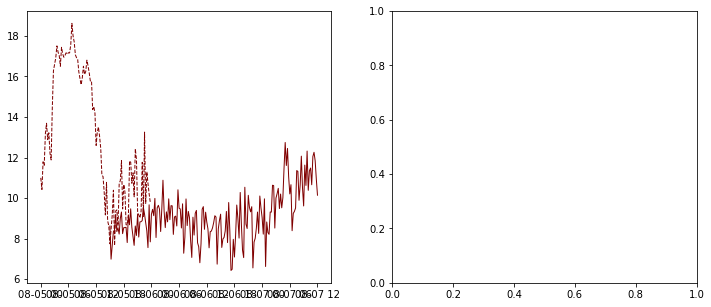

In [22]:
for col in data_dir_df.columns[:1]: 
    plot_wp_wrf_ts_taydiag(dlprofwind, col)
#     plot_wp_wrf_ts_taydiag(dlprofwstats, col)

In [46]:
data_dir_df.columns[:1]

Index(['2018-08-05'], dtype='object')

In [ ]:
dlprofwind_ncs

In [ ]:
dlprofwind

In [ ]:
plot_wp_wrf_ts_taydiag(dlprofwind, '2018-08-05')
# plot_wp_wrf_ts_taydiag(dlprofwstats, '2018-08-05')